2024-12-03 23:12:01.753847: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-12-03 23:12:01.788084: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1733289121.805280   25025 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1733289121.813096   25025 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-12-03 23:12:01.836963: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instr

Processing JNJ...
Epoch 1/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 940ms/step - loss: 0.0193 - mae: 0.1033 - val_loss: 0.0126 - val_mae: 0.1113
Epoch 2/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step - loss: 0.0415 - mae: 0.1792 - val_loss: 0.0210 - val_mae: 0.1449
Epoch 3/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step - loss: 0.0112 - mae: 0.0958 - val_loss: 0.0291 - val_mae: 0.1695
Epoch 4/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step - loss: 0.0112 - mae: 0.0923 - val_loss: 0.0230 - val_mae: 0.1488
Epoch 5/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step - loss: 0.0148 - mae: 0.1089 - val_loss: 0.0097 - val_mae: 0.0940
Epoch 6/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step - loss: 0.0084 - mae: 0.0777 - val_loss: 0.0011 - val_mae: 0.0282
Epoch 7/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step - loss: 0.0017 - mae: 0.0315 - val_loss: 0.0032 - val_mae: 0.0532
Epoch 8/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step - loss: 0.0017 - mae: 0.0331 - val_loss: 0.0122 - val_mae: 0.1091
Epoch 9/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step - l

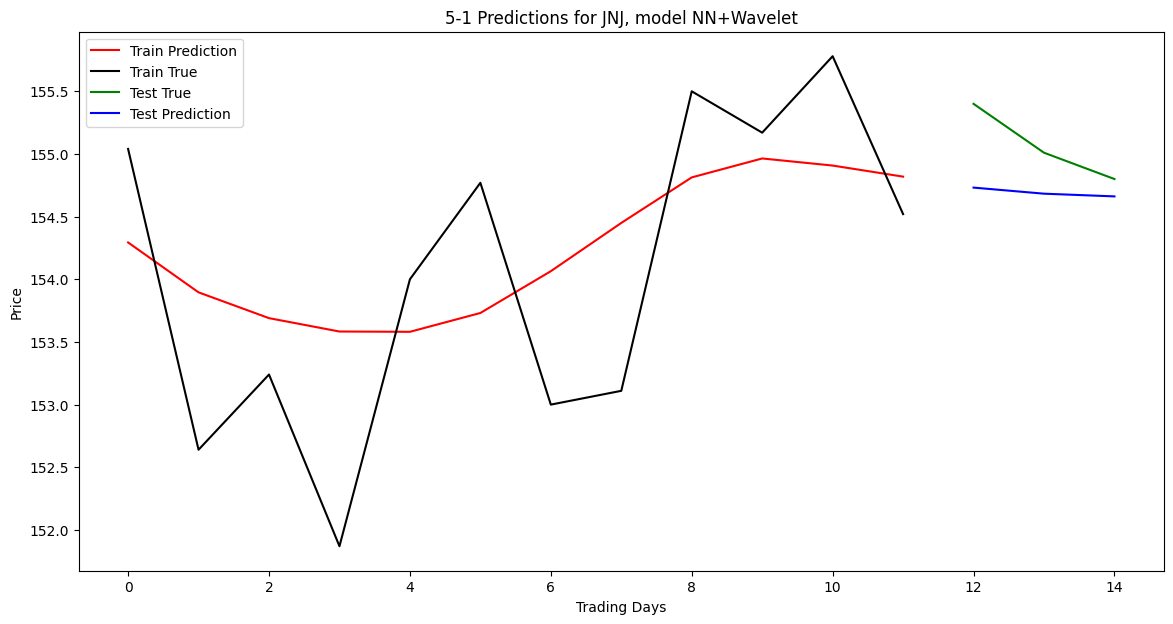

  Ticker       Model  Train MAE
0    JNJ  NN+Wavelet   0.545921


In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pywt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Bidirectional, Flatten, RepeatVector, LeakyReLU
from tensorflow.keras.callbacks import EarlyStopping
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
import requests,os
from datetime import datetime, timedelta
# Helper Function to fetch historical stock data
import yfinance as yf
def get_stock_data(ticker, start_date, end_date):
    try:
        # https://medium.com/nerd-for-tech/all-you-need-to-know-about-yfinance-yahoo-finance-library-fa4c6e48f08e
        #data = yf.Ticker(ticker).history(start=start_date, end=end_date)  
        data = yf.download(ticker, start=start_date, end=end_date)
        return data
    except Exception as e:
        return f"Error fetching data: {e}"
    
    
# Sentiment 
def fetch_news_and_sentiment(ticker, start_date, end_date):
    api_url = f"https://newsapi.org/v2/everything?q={ticker}&from={start_date}&to={end_date}&apiKey=7e9676fa277d423f8deff9a4894bd717"
    response = requests.get(api_url)
    news_data = response.json()

    headlines = []
    dates = []
    if "articles" in news_data:
        for article in news_data['articles']:
            headlines.append(article['title'])
            # Extract the publication date of the article
            dates.append(article['publishedAt'][:10])  # Extract the YYYY-MM-DD format

    # Perform sentiment analysis using VADER
    analyzer = SentimentIntensityAnalyzer()
    sentiment_data = []
    for headline, date in zip(headlines, dates):
        score = analyzer.polarity_scores(headline)
        sentiment_data.append({'date': date, 'sentiment': score['compound']})  # Store date and compound score

    return sentiment_data

# Function to aggregate daily sentiment scores
def aggregate_daily_sentiment(sentiment_data, start_date, end_date):
    # Convert to DataFrame
    sentiment_df = pd.DataFrame(sentiment_data)
    # print(sentiment_df[:30])
    sentiment_df['date'] = pd.to_datetime(sentiment_df['date'])

    # Group by date and calculate the average sentiment for each day
    daily_sentiment = (
        sentiment_df.groupby('date')['sentiment']
        .mean()
        .reindex(pd.date_range(start_date, end_date), fill_value=0)  # Fill missing days with 0 sentiment
    )
    print(daily_sentiment)
    return daily_sentiment
# Data Preprocessing Function
def preprocess_data(df, ticker, start_date, end_date, wavelet_transform=False, sentiment=False, seq_length=5):
    # Normalize Close prices
    scaler_close = MinMaxScaler(feature_range=(0, 1))
    df['Close_scaled'] = scaler_close.fit_transform(df['Close'].values.reshape(-1, 1))

    # Optionally apply Wavelet Transform to Close prices
    if wavelet_transform:
        wavelet = pywt.Wavelet('db6')
        def wavelet_transform(data, lvl=8):
            coeff = pywt.wavedec(data, wavelet, mode='symmetric', level=lvl)
            return coeff
        def inverse_wavelet_transform(coeff):
            for i in range(3):
                coeff[-(i + 1)] = np.zeros_like(coeff[-(i + 1)])
            return pywt.waverec(coeff, wavelet, mode='symmetric')
        
        close_prices = df['Close'].values
        wavelet_coeff = wavelet_transform(close_prices)
        reconstructed_close = inverse_wavelet_transform(wavelet_coeff)
        
        # Adjust the reconstructed data length to match the original DataFrame
        # reconstructed_close = np.pad(reconstructed_close, (0, len(df) - len(reconstructed_close)), mode='edge')
        reconstructed_close = np.pad(reconstructed_close, (0, max(0, len(df) - len(reconstructed_close))), mode='edge')

        df['Close_scaled'] = scaler_close.fit_transform(reconstructed_close.reshape(-1, 1))

    # Optionally include Sentiment data
    if sentiment:
        sentiment_data = fetch_news_and_sentiment(ticker, start_date, end_date)
        sentiment_df = pd.DataFrame(sentiment_data)
        print(sentiment_df)
        # Group by date and average sentiment
        sentiment_df['date'] = pd.to_datetime(sentiment_df['date'])  # Ensure 'date' is in datetime format
        daily_sentiment_scores = sentiment_df.groupby('date', as_index=False)['sentiment'].mean()
        
        df.index = pd.to_datetime(df.index)  # Convert stock_data index to datetime
        daily_sentiment_scores.index = pd.to_datetime(daily_sentiment_scores.index)  # Convert daily_sentiment index to datetime

        # Replace the "Sentiment" column in stock_data with values from daily_sentiment
        df['Sentiment'] = df.index.map(daily_sentiment_scores.get)

        # Fill any missing sentiment values with 0
        df['Sentiment'].fillna(0, inplace=True)

        scaler_sentiment = MinMaxScaler(feature_range=(0, 1))
        df['Sentiment_scaled'] = scaler_sentiment.fit_transform(df['Sentiment'].values.reshape(-1, 1))
        features = df[['Close_scaled', 'Sentiment_scaled']].values
    else:
        features = df[['Close_scaled']].values

    # Create sequences for LSTM
    X, y = [], []
    for i in range(len(features) - seq_length):
        X.append(features[i:i + seq_length])
        y.append(features[i + seq_length, 0])  # Target is the next Close value
    return np.array(X), np.array(y), scaler_close

# Build LSTM Model
# def build_lstm_model(input_shape, return_sequences=False):
#     model = Sequential([
#         Bidirectional(LSTM(units=256, return_sequences=True, input_shape=input_shape)),
#         Dropout(0.3),
#         Bidirectional(LSTM(units=128, return_sequences=return_sequences)),
#         Dropout(0.3),
#         RepeatVector(1),
#         Dense(units=64, activation='relu'),
#         Dense(units=32),
#         Flatten(),
#         Dense(units=1)
#     ])
#     model.compile(optimizer='adam', loss='mean_squared_error', metrics=['mae'])
#     return model
def build_lstm_model(input_shape, output_len, return_sequences=False):

    model = Sequential([
        Flatten(input_shape=input_shape),
        Dense(180),
        LeakyReLU(),
        Dense(360),
        LeakyReLU(),
        Dense(360),
        LeakyReLU(),
        Dense(output_len)
    ])
    model.compile(optimizer='adam', loss='mean_squared_error', metrics=['mae'])
    return model

# Train Model and Get Predictions
def train_and_predict(X_train, y_train, X_test, y_test, model, scaler_close):
    # Early stopping
    early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
    
    # Train the model
    model.fit(X_train, y_train, epochs=100, batch_size=32, validation_split=0.2, callbacks=[early_stopping])

    # Make predictions
    train_predictions = model.predict(X_train)
    test_predictions = model.predict(X_test)

    # Inverse transform predictions and true values
    train_predictions = scaler_close.inverse_transform(train_predictions)
    test_predictions = scaler_close.inverse_transform(test_predictions)
    y_train = scaler_close.inverse_transform(y_train.reshape(-1, 1))
    y_test = scaler_close.inverse_transform(y_test.reshape(-1, 1))

    return train_predictions, test_predictions, y_train, y_test

# Calculate Metrics
def calculate_metrics(y_true, y_pred):
    mae = mean_absolute_error(y_true, y_pred)/y_true * 100
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_true, y_pred)
    return mae, mse, rmse, r2

# Plot Results
def plot_results(df, seq_length, pred_len, split, y_train, train_predictions, y_test, test_predictions, ticker, model_type):
    plt.figure(figsize=(14, 7))
    index = range(len(df.index[seq_length::]))
    plt.plot(index[:split], train_predictions, label='Train Prediction', color='red')
    plt.plot(index[:split], y_train, label='Train True', color='black')
    plt.plot(index[split:], y_test, label='Test True', color='green')
    plt.plot(index[split:], test_predictions, label='Test Prediction', color='blue')
    plt.legend(loc = "upper left")
    plt.title(f"{seq_length}-{pred_len} Predictions for {ticker}, model {model_type}")
    plt.xlabel("Trading Days")
    plt.ylabel("Price")
    directory = f"{seq_length}-{pred_len}/lstm_wave/{ticker}"
    os.makedirs(directory, exist_ok=True)
    plt.savefig(directory)
    plt.show()


# Consolidated Function to Handle Multiple Tickers
def run_models_for_tickers(tickers, models=['LSTM', 'LSTM + Wavelet', 'LSTM + Sentiment', 'LSTM + Wavelet + Sentiment'], metrics=['MAE', 'MSE', 'RMSE', 'R2'], seq_length=5): # '
    results = []
    pred_len = 1
    for ticker in tickers:
        start_date = "2024-11-04"
        end_date = "2024-12-03"
        df = get_stock_data(ticker,start_date,end_date)  # Assume a function to load stock data for each ticker
        print(f"Processing {ticker}...")
        
        for model_type in models:
            # Preprocess data based on model type
            wavelet_transform = 'Wavelet' in model_type
            sentiment = 'Sentiment' in model_type
            X, y, scaler_close = preprocess_data(df, ticker, start_date, end_date, wavelet_transform=wavelet_transform, sentiment=sentiment, seq_length=seq_length)
            
            # Split data into training and testing sets
            split = int(0.8 * len(X))
            X_train, X_test = X[:split], X[split:]
            y_train, y_test = y[:split], y[split:]

            # Build and train model
            model = build_lstm_model(input_shape=(seq_length, X.shape[2]), output_len=pred_len, return_sequences=('Wavelet' in model_type))
            train_predictions, test_predictions, y_train, y_test = train_and_predict(X_train, y_train, X_test, y_test, model, scaler_close)
            
            y_train_true, y_test_true = df['Close'][seq_length:split+seq_length], df['Close'][split+seq_length:]

            metrics_results = calculate_metrics(y_test_true, test_predictions)
            train_metrics_results = calculate_metrics(y_train_true, train_predictions)
            results.append({
                'Ticker': ticker,
                'Model': model_type,
                'Train MAE': np.mean(train_metrics_results[0]),
                # 'Train MSE': train_metrics_results[1],
                # 'Train RMSE': train_metrics_results[2],
                # 'Train R2': train_metrics_results[3],
                # 'Test MAE': metrics_results[0],
                # 'Test MSE': metrics_results[1],
                # 'Test RMSE': metrics_results[2],
                # 'Test R2': metrics_results[3]
            })

            # Plot results
            plot_results(df, seq_length, pred_len, split, y_train_true, train_predictions, y_test_true, test_predictions, ticker, model_type)

    # Create DataFrame to store results
    results_df = pd.DataFrame(results)
    print(results_df)
tickers = ["JNJ"]#,"WMB","HMC","MSFT", "TM"] # TSLA","NVDA","AMZN","MSFT", "BIPC", 
models=['NN+Wavelet']#'LSTM', 'CNN', 'RandomForest', 'XGBoost', 'LightGBM', 'LSTM+Wavelet', 'CNN+Wavelet', 'RandomForest+Wavelet', 'XGBoost+Wavelet', 'LightGBM+Wavelet']
# models=['LSTM + Sentiment + Wavelet']
# Example Usage
results_df = run_models_for_tickers(tickers, models, metrics=['MAE', 'MSE', 'RMSE', 'R2'])
